# Conductance-Based Spiking Neural Network (conductance-SNN)

## Install required packages

Install required packages

In [1]:
import numpy as np
import pylab as pl
import math
from matplotlib import colors as mcolors
from mpl_toolkits.mplot3d import Axes3D
import random
import os
import matplotlib.animation as animation
import copy
from scipy.signal import sweep_poly
from scipy.ndimage.filters import gaussian_filter1d

## Functions used for simulation

### Initialize weights

Initialize weights

In [2]:
def initialize_weights(N, d, positive_signal=False):
    """ Initialize decoding weights of the different neurons. 
    
    Parameters
    ----------
    N : int
        number of neurons
    d : int
        number of dimensions
    
    Returns
    ----------
    D : array
        weights per dimension, size (N, d)
    
    """
    
    D = np.zeros((N, d))
    
    if positive_signal == True:
        if d == N:
            D = np.identity(N)
        else:
            D = np.random.uniform(1/N, 1, size=(N, d))
    else:
        if d == 1:
            weights = np.linspace(0, 2 * np.pi, N + 1)       
            D = np.zeros((N,d))
            D[:, 0] = [np.sin(weight) for weight in weights[0:N]]
        elif d == 2:
            weights = np.linspace(0, 2 * np.pi, N + 1)       
            D[:, 0] = [np.sin(weight) for weight in weights[0:N]]
            D[:, 1] = [np.cos(weight) for weight in weights[0:N]]
        else:
            D = np.random.normal(0, 0.5, size=(N, d)) 
               
    return D

### Initialize parameters

Initialize parameters

In [3]:
def initialize_params(N, d, dt, iterations, D, beta):
    """ Initialize variables and parameters. 
    
    Parameters
    ----------
    N : int
        number of neurons
    d : int
        number of dimensions
    dt : int
        time step
    iterations : int
        length of the simulation
    weight : string, optional
        all neurons have same weights ("homogeneous") or neurons have different weights ("heterogeneous")
    gamma : int, optional
        read-out weight of the neurons (only applies when weights="homogeneous")
    beta : int
        cost
        
    Returns
    ----------
    t : 1D-array
        timesteps
    x_est : array
        input estimate per timestep, size (d, iterations)
    o : array
        spike trains, with value 0 if there is no spike and value 1/dt if there is a spike,
        size (N, iterations) 
    voltage : array
        voltages, size (N, iterations) 
    T : 1D-array
        threshold of the neurons
    
    """
    
    # timesteps
    t = np.arange(0, iterations) * dt

    # voltage
    voltage = np.zeros((N, iterations))

    # input estimate
    x_est = np.ones((d, iterations)) * 0

    # spike train
    o = np.zeros((N, iterations))

    # threshold
    T = [(np.dot(weight, weight) + beta)/2 for weight in D]

    return (t, voltage, x_est, o, T)

### Time varying signal

Create time varying signal

In [4]:
def time_varying_signal(d, positive_signal=False):
    """ Initialize time varying, sinusoidal input signal. 

    Parameters:
    d: int
        number of dimensions
    positive: boolean, optional
        positive input signal only (True) or not (False)
    
    Returns
    ----------
    x : array
        input per timestep, size (d, iterations)
    c : array
        sum of the input and input derivative per timestep, size (d, iterations)
        
    """
    
    c = []
    x = []
    
    # number of sinus periods (total # of sinus periods = 2 * cycles)
    cycles = 2
    t = np.linspace(0, np.pi, d + 1)       # starting points of d-dimensioan sinusoidal input signals
    
    for i in range(d):
        
        # create input signal
        x_temp = []
        if positive_signal == True:
            x_temp = np.sin(2 * np.linspace(-cycles * np.pi, cycles * np.pi, iterations) + t[i]) + 5
        else:
            x_temp = np.sin(2 * np.linspace(-cycles * np.pi, cycles * np.pi, iterations) + t[i])
        
        # compute derivative
        dxdt = np.diff(x_temp)/dt
        c_temp = x_temp[:-1] + dxdt

        c.extend(c_temp)
        x.extend(x_temp)

    c = np.asarray(c).reshape((d, iterations - 1))
    x = np.asarray(x).reshape((d, iterations))

    return(x, c)

In [5]:
def time_varying_signal_plateau(c_upp=[1, 1], constant=False):
    """ Initialize time varying input signal with a plateau. 
    
    Parameters
    ----------
    c_upp : int, optional
        value of the plateau
    constant : boolean, optional
        create a constant, time-invariant (True) or a constant (False) input signal
    
    Returns
    ----------
    x : array
        input per timestep, size (d, iterations)
    c : array
        sum of the input and input derivative per timestep, size (d, iterations)
        
    """
        
    c = []
    x = []
    
    if constant == True:
        # creates constant input signal
        x_t = np.ones((d, iterations))
        for i in range(d):
             x_t[i, :] *= c_upp[i]

        c = np.asarray(x_t).reshape((d, iterations))
        x = np.asarray(x_t).reshape((d, iterations))
    
    else:
        # creates time-variant input signal
        x_t = np.ones((d, iterations))
        for i in range(d):
             x_t[i, :] *= c_upp[i]
        step = int(np.round(iterations * 0.1))
        x_t[:, 0:2 * step] = 0
        x_t[:, iterations - 2 * step:iterations] = 0

        # smooth signal
        x = gaussian_filter1d(x_t, sigma=20)
        
        # compute derivative
        for i in range(d):
            dxdt = np.diff(x[i,:])/dt
            c.extend(x[i, :-1] + dxdt)

        c = np.asarray(c).reshape((d, iterations - 1))
        x = np.asarray(x).reshape((d, iterations))
        
    return (x, c)

### Run simulation

In [140]:
def run(rho, beta, E_e=1, E_i=-1, lambda_constant=False, var=0):
    """ Run simulation of spike coding network. At each time step, the voltage and input estimate is computed
    using the Euler's method. The network follows a spike rule that if one of the voltage reaches threshold the
    network outputs a spike wherafter the voltages and input estimate are updated. 
    
    Parameters
    ----------
    rho : int
        network parameter
    beta : int, optional
        cost
    E_e : int, optional
        excitatory reversal potential
    E_i : int, optional
        inhibitory reversal potential
    lambda_constant : boolean, optional
        defines lambda as a constant (True) or as its true value (False)
    var : int, optional
        value of lambda (only applies when lambda_constant=True) 
    
    """
    
    # initialize parameters
    lambda_val = 0
    x_est_min = 0
    r = np.zeros((N, 1))
    
    # initialize exponential filter
    tau = 1.5
    y = [exponential_filter(i, tau) for i in np.arange(0, iterations) * dt]
    
    for t in range(1, iterations):
        
        # compute lambda
        if lambda_constant == False:
            for i in range(N):
                X_est = np.dot(D.T, r)
                lambda_val = 1/np.dot(D, x[:, t - 1] + x_est[:, t - 1])
        elif lambda_constant == True:
            lambda_val = 1/var
            
        #lambda_val = 1
                
        # update voltages
        dVdt = (lambda_val + rho) * (-rho * voltage[:, t - 1] + \
                             np.dot(D, c[:, t - 1]) * (E_e - voltage[:, t - 1]) + \
                             np.dot(np.dot(D, D.T) + beta * np.identity(N), o[:, t - 1]) * (E_i - voltage[:, t - 1]))
        voltage[:, t] = voltage[:, t - 1] + dt * dVdt
        
        # check for neurons with voltages above threshold
        neurons = np.arange(0, N, 1)
        above_threshold = neurons[np.where(voltage[:, t] > T)]

        # reset neurons' voltages when threshold is exceeded
        if len(above_threshold) > 0:

            # select spiking neuron
            spike_neuron = np.random.choice(above_threshold)
            
            # update spikes
            o[spike_neuron, t] = 1/dt

        # update readout
        dxestdt = -x_est[:, t - 1] + np.dot(D.T, o[:, t])
        x_est[:, t] = x_est[:, t - 1] + dt * dxestdt

        # compute firing rate
        for i in range(N):
            r_temp = firing_rate(o[i, :], y)
            r[i] = r_temp[t] * dt

## Functions to visualize data

### Decoding weights

In [7]:
def plot_weights():
    """ Plot the weights for N neurons (2D and 3D input signal). """
    
    # plot weights for (d=)2 or (d=)3 dimensional-input
    if d == 2:
        plots = 2
        pl.subplots(plots, 1, figsize=(15, 15)) # figsize=(12, 4)
        pl.axhline(y=0, color='k', alpha=0.6)
        pl.axvline(x=0, color='k', alpha=0.6)
   
        for n in range(2):
            pl.subplot(1, 2, n+1)
            if n==0:
                for i in range(N):
                    pl.arrow(0, 0, D[i, 0], D[i, 1], color=color[i], length_includes_head=True, head_width=0.02)
            else:
                for i in range(N):
                    pl.scatter(D[i][0], D[i][1], color=color[i], label='N%i' %(i+1))
            pl.axis('square')    
            pl.xlabel('D1')
            pl.ylabel('D2')
            pl.xlim(min(D[:, 0]) - 0.1, max(D[:, 0]) + 0.1)
            pl.ylim(min(D[:, 1]) - 0.1, max(D[:, 1]) + 0.1)

    elif d == 3:
        fig = pl.figure()
        ax = pl.axes(projection='3d')
        
        # plot weights as points
        for i in range(N):
            ax.scatter3D(D[i][0], D[i][1], D[i][2], color=color[i], s=50, label='N%i' %(i+1))
        ax.set_xlabel('D1')
        ax.set_ylabel('D2')
        ax.set_zlabel('D3')
    else:
        print("No plot generated: function for 2D and 3D signal input only. ")

### Bounding Box

In [204]:
def plot_bounding_box():
    """ Plot bounding box. 
        
    Returns
    ----------
    fig : plot
        figure with the bounding box
    
    """
    
    fig = pl.figure(figsize=(15, 15))
    pl.axis('square')
    pl.axis('off')
    pl.axhline(y=0, color='k')
    pl.axvline(x=0, color='k')
    val_min = -0.1
    val_max = 2 * c_upp[0]
#     pl.xlim(min(D[:, 0]) - val_min, max(D[:, 0]) + val_max)
#     pl.ylim(min(D[:, 1]) - val_min, max(D[:, 1]) + val_max)
#     val_min2 = 2.5
#     val_max2 = 6
    val_min2 = 0
    val_max2 = 4
    pl.xlim(val_min2, val_max2)
    pl.ylim(val_min2, val_max2)
    w = 3
    
    for i in range(N):
        if D[i, 0] != 0 and D[i, 1] != 0:
            x1 = np.zeros(2)
            x2 = np.linspace(-1000, 1000, 2)
            for j in range(2):
                x1[j] = (D[i, 0] * c_upp[0] * (1 - T[i]) + D[i, 1] * c_upp[1] * (1 - T[i]) - D[i, 1] * x2[j] * (1 + T[i]))/(D[i, 0] * (1 + T[i]))
#             pl.fill_between(x1, x2, x2 + 2 * D[i, 1], color='blue', alpha=0.1)
            pl.fill_between(x1, 0, x2, color='black', alpha=0.1)
            pl.plot(x1, x2, color='black', lw=w)
            #pl.plot(x1 + D[i, 0], x2 + D[i, 1], 'k--', alpha=0.5, lw= w - 2)
        elif D[i, 0] == 0:
            x1 = np.linspace(-1000, 1000, 2)
            x2 = np.zeros(2)
            for j in range(2):
                x2[j] = (D[i, 1] * c_upp[1] * (T[i] - 1))/ (D[i, 1] * (- 1 - T[i]))
#             pl.fill_between(x1, x2, x2 + D[i, 1], color='blue', alpha=0.1)
            pl.fill_between(x1, val_min2, x2, color='black', alpha=0.1)
            pl.plot(x1, x2, color='black', lw=w)
            #pl.plot(x1 + D[i, 0], x2 + D[i, 1], 'k--', alpha=0.5, lw= w - 2)
        if D[i, 1] == 0:
            x1 = np.zeros(2)
            x2 = np.linspace(-1000, 1000, 2)
            for j in range(2):
                x1[j] = (D[i, 0] * c_upp[0] * (T[i] - 1))/ (D[i, 0] * (- 1 - T[i]))
#             pl.axvspan(x1[0], x1[0] + D[i, 0], color='blue', alpha=0.1)
            pl.axvspan(val_min2, x1[0], color='black', alpha=0.1)
            pl.plot(x1, x2, color='black', lw=w)
            #pl.plot(x1 + D[i, 0], x2 + D[i, 1], 'k--', alpha=0.5, lw= w - 2)        
            
    return fig

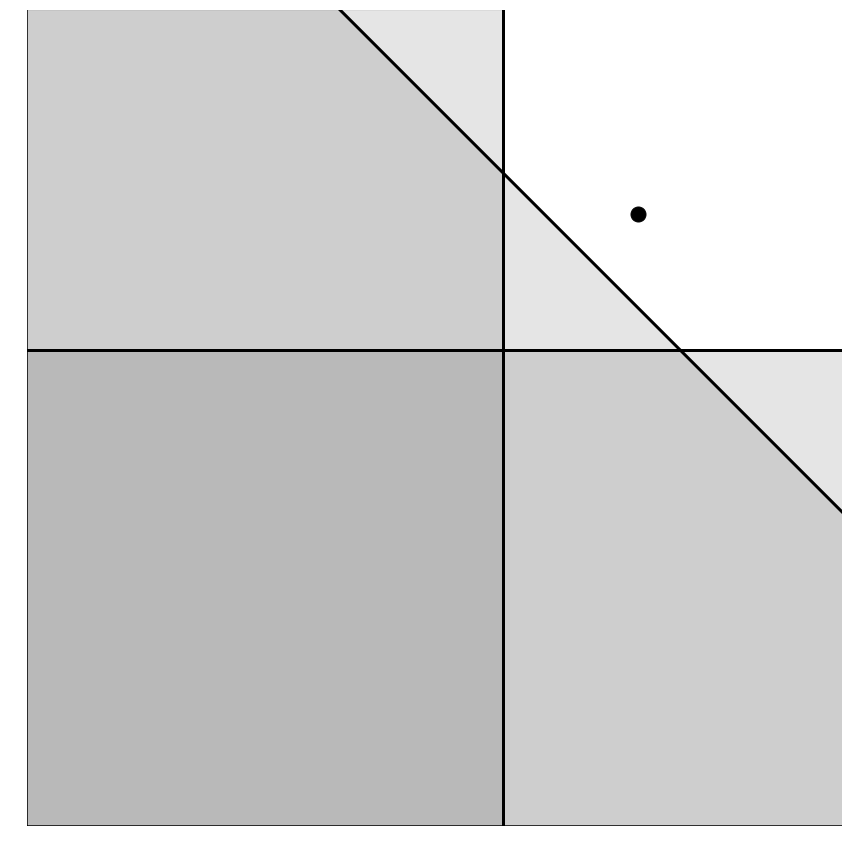

In [205]:
plot_error_space(plot_error=False, plot_true_signal=True, start=500)

In [10]:
def plot_error_space(plot_error=False, plot_true_signal=False, start=0):
    """ Plots 2D/3D error space with the bounding box. 
    
    Parameters
    ----------
    plot_error : boolean, optional
        plot error at every timestep (True) or not (False)
    plot_true_signal: boolean, optional
        plots input signal (True) or not (False)
    start : int, optional
        plots error from this timepoint onwards
        
    """

    # enable LaTeX
    pl.rc('text', usetex=True)
    
    if d == 2:
        # 2-dimensional input signal
        fig = plot_bounding_box()
        if plot_error == True:
            pl.plot(x_est[0, start:iterations],x_est[1, start:iterations], color='gray')
        if plot_true_signal==True:
            pl.plot(c_upp[0], c_upp[1], 'ko', markersize=15)
            
    elif d == 3:
        # 3-dimensional input signal
        plots = d
        counter = 0
        idx1 = [0, 1, 2]
        idx2 = [1, 2, 0]
        idx3 = [2, 0, 1]
        
        for i in range(plots):
                counter = counter + 1
                fig = plot_bounding_box(idx1[i] + 1, idx2[i] + 1, idx3[i] + 1)
                pl.xlabel('$x_{%i} - \hat{x}_{%i}$' %(idx1[i] + 1, idx1[i] + 1), fontsize=20)
                pl.ylabel('$x_{%i} - \hat{x}_{%i}$' %(idx2[i] + 1, idx2[i] + 1), fontsize=20)
                pl.xlim(-1, 1)
                pl.ylim(-1, 1)
    else:
        print("2D and 3D signal input only.")

In [11]:
def bounding_box_animation_2D(frames, interval=70):
    """ Plot animation of the coding error through time with respect to the bounding box.
    
    Parameters
    ----------
    frames: int
        number of frames
    interval: int, optional
        time between frames
        
    Returns
    ----------
    fig : figure
        animated figure with the bounding box and the error over time
    
    """
    
    if d == 2:
        
        # file
        file = 'C:/Users/amber/MachensLab/BoundingBox/Conductance_D' + str(d) + '_N' + str(N) + '.gif'

        # initiate plot
        fig = plot_bounding_box(1, 2)
        pl.axhline(y=0, color='k', alpha=0.6)
        pl.axvline(x=0, color='k', alpha=0.6)
        point, = pl.plot([], [], 'k', marker='o')

        # compute representation error over time
        start = 400
        error = x[:, start:iterations] - x_est[:, start:iterations]
        error_x1 = error[0, :]
        error_x2 = error[1, :]

        def animate(i):
            x = error_x1[i - 1:i]
            y = error_x2[i - 1:i]
            point.set_data(x, y)
            return point,

        # runs animation
        ani = animation.FuncAnimation(fig, animate, frames=frames, interval=interval, blit=True)
        ani.save(file, writer='imagemagick') # save as .gif
        pl.show()
        
        return fig
        
    else:
        print("2D signal input only.")

### Firing rate

Initialize exponential filter for the firing rate:

$r_{k}(t) = \int^{\infty}_{0} e^{-t'/\tau} s_{k}(t - t') dt'$

In [12]:
def exponential_filter(t, tau):
    """ Exponential filter. 
    
    Parameters
    ----------
    t : 1D-array
        timesteps
    tau : int
        rate of change
    
    Returns
    ----------
    filter : 1D-array
        exponential filter used for convolution
        
    """
    
    filter = np.exp(-t/tau)
    
    return filter

In [13]:
def firing_rate(spike_train, filt):
    """ Compute firing rate by the convolution of exponential filter and spike train. 
    
    Parameter
    ----------
    spike_train : 1D-array
        spike train
    filt : 1D-array
        filter for the convolution
    
    Returns
    ----------
    convolution : 1D-array
        convolution of the spike train with the filter
    
    """
    
    convolution = np.convolve(spike_train, filt)
    
    return convolution

Compute and plot firing rate per neuron

In [14]:
def visualize_firing_rate(tau):
    """ Compute and visualize firing rate of each neuron. 
    
    Parameter
    ----------
    tau : int
        rate of change
    
    """
    
    # spike trains
    spike_trains = copy.copy(o)
    spike_trains[spike_trains == 1/dt] = 1

    # initialize exponential filter
    tau = 1.5
    y = [exponential_filter(i, tau) for i in t]

    # initialize plots
    plots = N
    pl.subplots(plots, 1, figsize=(16, 2*N))
    w = 4
    counter = 1

    # compute input estimate 
    for i in range(N):

        # compute firing rate
        firingrate = firing_rate(spike_trains[i, :], y)

        # plot firing rate
        pl.subplot(plots, 1, counter)
        pl.axis('off')
        counter = counter + 1
        pl.plot(t, firingrate[0: iterations], color=color[i, :], label='N%i' %(i + 1), lw=w)
        pl.ylim(-0.1, max(firingrate) + 0.5)
        pl.xticks([])
        pl.yticks(fontsize=15)
    
    pl.xlim(0, iterations * dt)
    pl.xticks(fontsize=15)

### Membrane voltage 

In [15]:
def visualize_voltage(rho):
    """ Compute and visualize membrane voltage of each neuron. 
    
    Parameters
    ----------
    rho: int
        network parameter        
    
    Returns
    ----------
    voltage_offline : array
        voltages computed using the offline method, size (N, iterations)
    
    """
    
    # spike trains
    spike_trains = copy.copy(o)
    spike_trains[spike_trains == 1/dt] = 1

    # initialize exponential filter
    tau = 1
    y = [exponential_filter(i, tau) for i in t]
    
    # compute input estimate (by method 2)
    x_est_offline = np.zeros((d, iterations))
    for j in range(iterations):
        for i in range(N):
            firingrate = firing_rate(spike_trains[i, :], y)
            x_est_offline[:, j] += D[i, :] * firingrate[j] 
    
    # compute voltage (by method 2)
    voltage_offline = np.zeros((N, iterations))
    for j in range(iterations):
        voltage_offline = np.dot(D, x - x_est_offline) / np.dot(D, x + x_est_offline + rho)

    # plot voltages
    counter = 1
    pl.subplots(N, 2, figsize=(14, 4))

    for i in range(N):
        pl.subplot(N, 2, counter)
        if counter == 1:
            pl.title(r'Online $\frac{dV_{i}}{dt} = D_{i}^{T}(\frac{x}{\tau} + \dot{x}) (1 - V_{i}) + \sum^{N}_{k = 1} (D_{i}^{T} D_{k} s_{k}) (-1 - V_{i})$',  fontsize=20)
        counter = counter + 1
        pl.plot(voltage[i, :], color=color[i, :], label='N%i' %i)
        pl.plot(t, np.ones(iterations) * T[i], color='gray', label='threshold') 
        pl.ylabel('voltage')
        pl.xlabel('time')
        
        pl.subplot(N, 2, counter)
        if counter == 2:
            pl.title(r'Offline $V_{i} = \frac{D_{i}(x - \hat{x})}{D_{i}(x + \hat{x} + \rho)}$', fontsize=20)
        counter = counter + 1
        pl.plot(voltage_offline[i, :], color=color[i, :], label='N%i' %i)
        pl.plot(t, np.ones(iterations) * T[i], color='gray', label='threshold') 
        pl.xlabel('time')
        pl.legend()
        
    return voltage_offline

In [16]:
def plot_voltage_diff(voltage_online, voltage_offline):
    """ Plot difference between online and offline voltage.
    
    Parameters
    ----------
    voltage_online : array
        voltages computed using the online method, size (N, iterations)
    voltage_offline : array
        voltages computed using the offline method, size (N, iterations)
    
    """
    
    pl.rc('text', usetex=True)
    pl.plot(t, voltage_online - voltage_offline, 'k')
    pl.ylim(-1, 1)
    pl.ylabel(r'$V_{online} - V_{offline}$')
    pl.xlabel('time')

### Visualize results simulation

In [17]:
def zero_to_nan(spike_trains):
    """Replace every 0 with 'nan' and return a copy.
    
    Parameters
    ----------
    spike_trains : array
        spike trains of the different neurons
    
    Returns
    ----------
    o_Nan : array
        array where every 0 is replaced by NaN, size (spike_trains.shape)
        
    """
    
    o_Nan = [float('nan') if x==0 else x for x in spike_trains]
    
    return o_Nan

In [168]:
def visualize(color, plot_voltage=True, plot_c=False, plot_sum=False, plot_E=False):
    """ Visualize results of the simulation of the spike coding network. Return one plot with the input and input estimate,
    one plot with the spike trains, and N plots for the voltages.
    
    Parameters
    ----------
    color : array
        RGB values for the different neurons, size (N, 3)
    plot_voltages : boolean, optional
        voltages are plotted (True) or not (False)
    plot_c : boolean, optional
        sum of input plus input derivative is plotted (True) or not (False)
    
    """ 
    
    # initialize plots
    if plot_voltage == True:
        plot = d + 1 + N
    else:
        plot = d + 1
    pl.subplots(plot, 1, figsize=(16, 15))
    pl.subplots_adjust(hspace=1)
    pl.rc('text', usetex=True)
    counter = 1
    w = 4

    # plot input and input estimate
    for i in range(d):
        pl.subplot(plot, 1, counter)
        counter += 1
        pl.axis('off')
        pl.plot(t, x_est[i,:], label=r'$\hat{x}_{%i}$' %(i+1), color='gray', lw=w)
        pl.plot(t, x[i,:], label='$x_{%i}$' %i, color='k', lw=w)
        if plot_sum == True:
            pl.plot(t, x[i] + x_est[i], color='orange', label=r'$x + \hat{x}$', alpha=0.5)
        if plot_c == True and constant == True and sinusoidal == False:
            pl.plot(t, c[i, :], '--k', label=r'$x + \dot{x}$', alpha=0.2, lw=w)
        elif plot_c == True and constant == False:
            pl.plot(t[:-1], c[i, :], '--k', label=r'$x + \dot{x}$', alpha=0.2, lw=w)
        elif plot_c == True and sinusoidal == True:
            pl.plot(t[:-1], c[i, :], '--k', label=r'$x + \dot{x}$', alpha=0.2, lw=w)       
        pl.xlim(0, iterations * dt)
    
    # plot spike trains
    pl.subplot(plot, 1, counter)
    counter += 1
    pl.axis('off')
    pl.xlim(0, iterations * dt)
    spike_times = []
    for i in range(N):
        idx = np.where(o[i, :] == 1/dt)
        temp = [t[i] for i in idx[0]]
        spike_times.append(temp)
    pl.eventplot(spike_times, linelengths=[0.8], color=color, lw=w)

    # plot voltage per neuron over time
    if plot_voltage == 1:
        for i in range(N):
            pl.subplot(plot, 1, counter)
            counter += 1
            pl.xlim(0, iterations * dt)
            pl.axis('off')
            pl.plot(t, voltage[i], color=color[i, :], label='voltage', lw=w)
            pl.plot(t, np.ones(iterations) * T[i], color='gray', alpha=0.4, lw=2)
            if plot_E == True:
                pl.plot(t, np.ones(iterations) * E_e, '--r', alpha=0.5, label='Reversal potential E', lw=w)
                pl.plot(t, np.ones(iterations) * E_i, '--b', alpha=0.5, label='Reversal potential I', lw=w)

## Run simulation

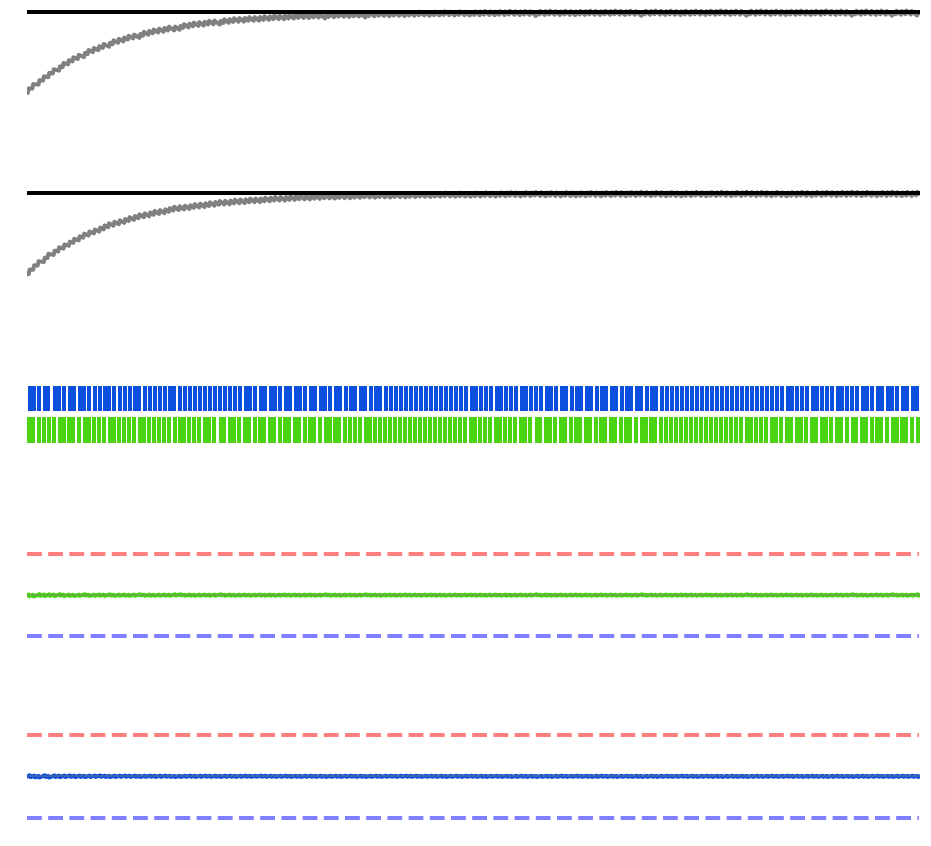

In [220]:
# Run simulation and plot results for given parameters
N = 2                                                    # number of neurons
d = 2                                                    # number of dimensions of input signal
dt = 0.01                                                 # step size
iterations = 1000                                       # number of time steps
positive_signal = True                                   # allow negative or only positive input signal
constant = True                                           # create constant or time-variant input signal
sinusoidal = False                                       # create sinusoidal wafevorm as input signal
c_upp = [3, 3]                                           # input value
rho = np.ones(N) * 0.1
tau = 1                                                  # time constant
beta = 0.0                                               # cost
E_e = 1                                                  # excitatory reversal potential
E_i = -1                                                 # inhibitory reversal potential
lambda_constant = False                                  # indicates use of lambda                   
var = 1
color = np.random.randint(0, 255, size=(N, 3))/255       # color map for plotting the different neurons
plot_c = False                                            # plot the input + input der (=c) or only input signal
plot_voltage= True                                       # plot the voltages
plot_E = True                                            # plot reversal potentials
plot_sum = False                                         # plot sum of input and readout

#################################### COLOR ####################################
color = np.random.randint(0, 255, size=(N, 3))/255       
#color = np.array([[0.1254902 , 0.2627451 , 0.90196078]])
# color = np.array([[0.74901961, 0.79215686, 0.09411765],
#                 [0.69803922, 0.87843137, 0.44705882]])
#                 [0.89019608, 0.96470588, 0.03921569],
#                 [0.04313725, 0.39607843, 0.30588235]])
# color = np.array([[0.1254902 , 0.2627451 , 0.90196078],
#                   [0.3372549 , 0.54901961, 0.96862745],
#                   [0.49803922, 0.63921569, 0.6       ],
#                   [0.22352941, 0.68235294, 0.37647059]])
#                   [0.        , 0.50196078, 0.        ]])
# color = np.array([[0.1254902 , 0.2627451 , 0.90196078]])
#        [0.3372549 , 0.54901961, 0.96862745],
#        [0.49803922, 0.63921569, 0.6       ]])
# color = np.array([[0.1254902 , 0.2627451 , 0.90196078], 
#        [0.3372549 , 0.54901961, 0.96862745]])
#        [0.49803922, 0.63921569, 0.6       ]])

#################################### WEIGHT ####################################
D = initialize_weights(N, d, positive_signal=positive_signal) 
# D = np.array([[0.1],
#               [-0.1]])
# D = np.array([[0.5, 0],
#               [.2, .2],
#               [0, 0.5]])
# D = np.array([[0.5, 0.5]])
# D = np.array([[0.5, 0],
#               [0, 0.5],
#               [0, 0.5],
#               [0.5, 0]])


# D = D/5
#D = np.identity(N)
# D = np.array([[0.5, 0],
#             [0.5, 0.5],
#             [0, 0.5]])
D = np.array([[0.5, 0],
             [0, 0.5]])

D = D/3
# D = np.array([[ 0.        ,  1.        ],
#        [ 0.95105652,  0.30901699],
#        [ 0.58778525, -0.80901699],
#        [-0.58778525, -0.80901699],
#        [-0.95105652,  0.30901699]])

# run simulation
t, voltage, x_est, o, T = initialize_params(N=N, d=d, dt=dt, iterations=iterations, D=D, beta=beta)                
if sinusoidal == True:
    x, c = time_varying_signal(d, positive_signal=positive_signal)                                
else:
    x, c = time_varying_signal_plateau(c_upp=c_upp, constant=constant)
# x_est[:, 0] = [5, 6]
# x_est[:, 0] = c_upp
run(rho, beta, E_e, E_i, lambda_constant=lambda_constant, var=var)                             
visualize(color, plot_voltage=plot_voltage, plot_c=plot_c, plot_sum=plot_sum, plot_E=plot_E)            

array([[ 0.1],
       [-0.1]])

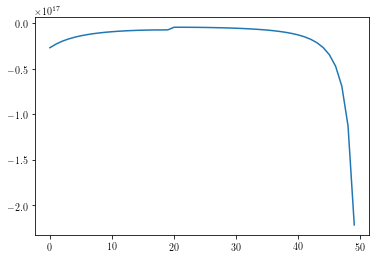

In [182]:
pl.plot(voltage[0, 200:350])
D

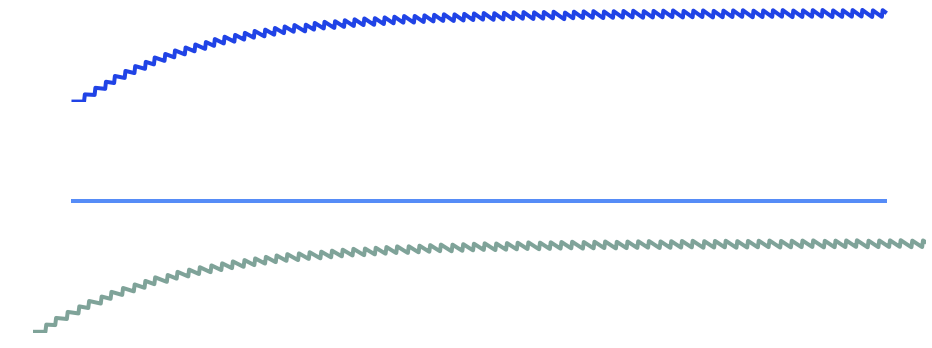

In [225]:
visualize_firing_rate(tau)

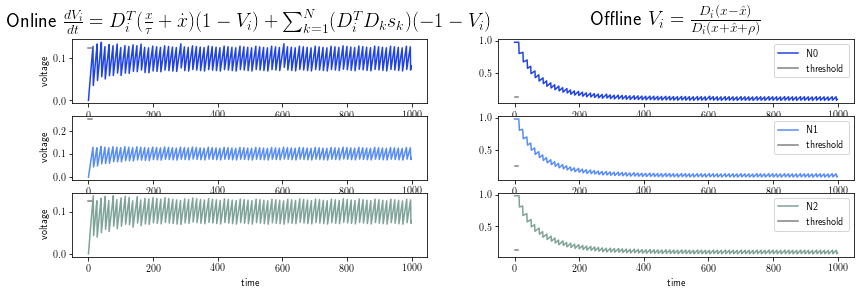

In [227]:
voltage_offline = visualize_voltage(rho)

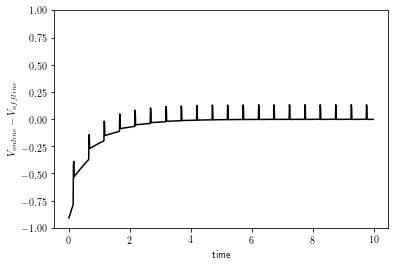

In [129]:
neuron = 2
if neuron < 1 or neuron > N:
    print("Enter valid neuron")
else:
    plot_voltage_diff(voltage[neuron - 1, :], voltage_offline[neuron - 1, :])

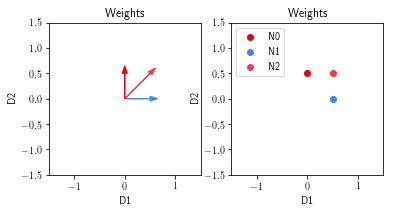

In [141]:
plot_weights()

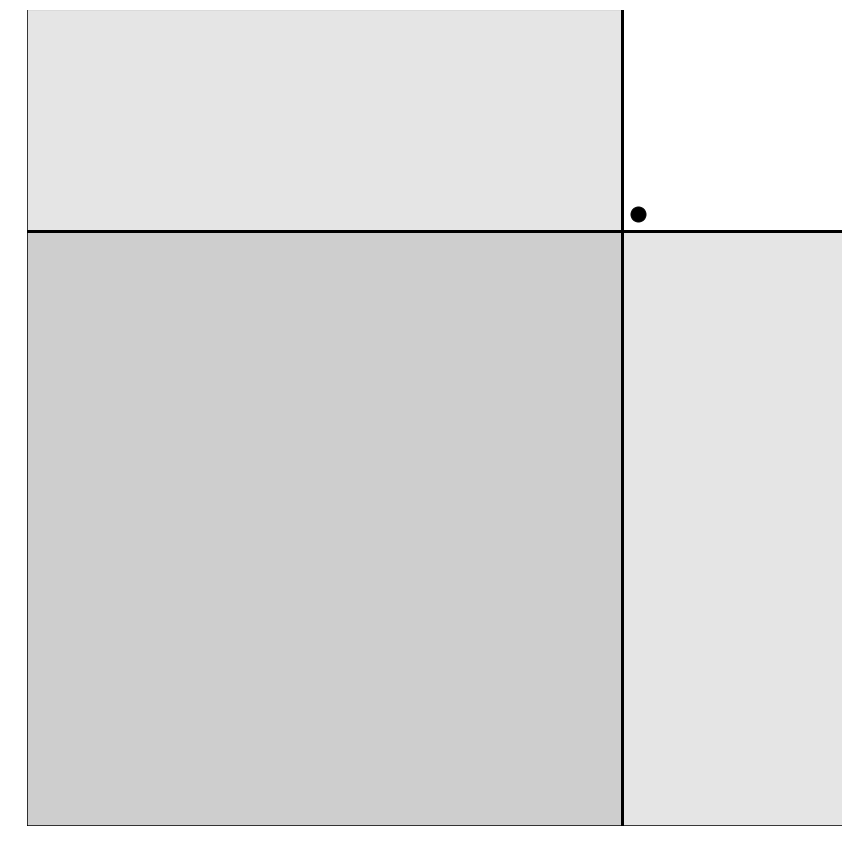

In [221]:
plot_error_space(plot_error=False, plot_true_signal=True, start=500)

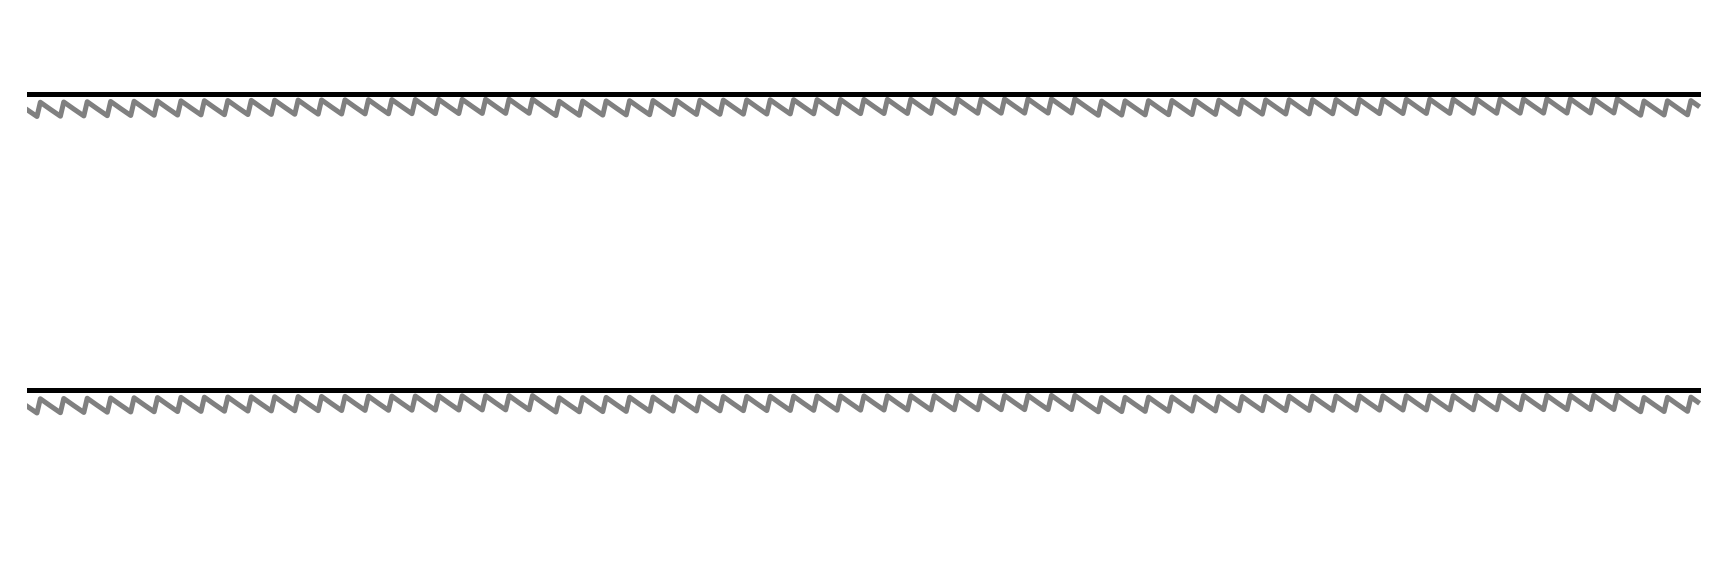

In [216]:
pl.subplots(2, 1, figsize=(30, 10))
counter=1
w = 5

start = 500

for i in range(d):
    pl.subplot(2, 1, counter)
    pl.ylim(1, c_upp[i] + 1)
    counter += 1
    pl.axis('off')
    pl.plot(t[start:iterations], x_est[i,start:iterations], label=r'$\hat{x}_{%i}$' %(i+1), color='gray', lw=w)
    pl.plot(t[start:iterations], x[i,start:iterations], label='$x_{%i}$' %i, color='k', lw=w)
    if plot_sum == True:
        pl.plot(t, x[i] + x_est[i], color='orange', label=r'$x + \hat{x}$', alpha=0.5)
    if plot_c == True and constant == True:
        pl.plot(t, c[i, :], '--k', label=r'$x + \dot{x}$', alpha=0.2, lw=w)
    elif plot_c == True and constant == False:
        pl.plot(t[:-1], c[i, :], '--k', label=r'$x + \dot{x}$', alpha=0.2, lw=w)
    pl.xlim(start * dt, iterations * dt)

## plot voltages and spikes in one plot

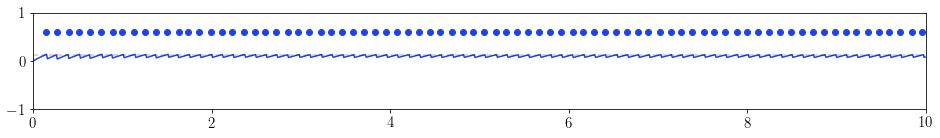

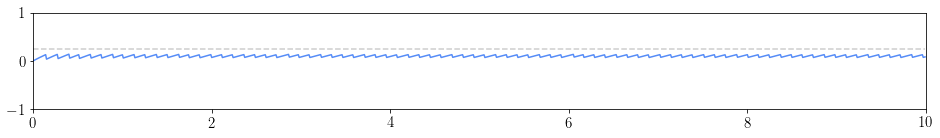

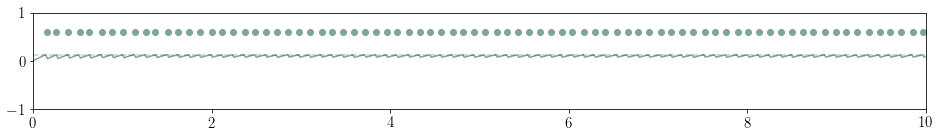

In [229]:
def LM_plot_voltage():
    """ Plot voltages, spike trains and thresholds per neuron. """
    
    counter = 1
    
    for i in range(N):
        
        # initialize plots
        fig= pl.figure(figsize=(16,6))
        pl.subplot(N, 1, counter)
        counter = counter + 1
        pl.xlim([0, iterations * dt])
        pl.xticks()
        pl.tick_params(labelsize=15)
        pl.ylim(-1, 1)
        
        # plot data
        pl.plot(t, voltage[i - 1], color=color[i, :], label='N%i'%i)
        pl.plot(t, np.ones(iterations) * T[i], '--k', alpha=0.2)
        values = zero_to_nan(o[i, :] * 0.006) 
        pl.scatter(t, values, color=color[i, :], label='Neuron %i' %i)
    
LM_plot_voltage()